# TinyTimeMixer (TTM) using single dataset - traffic



In [1]:
# Install the tsfm library
# ! pip install "granite-tsfm[notebooks] @ git+https://github.com/ibm-granite/granite-tsfm.git@v0.2.22"

## Imports

In [3]:
import math
import os
import tempfile

import pandas as pd
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR
from transformers import EarlyStoppingCallback, Trainer, TrainingArguments, set_seed
from transformers.integrations import INTEGRATION_TO_CALLBACK
from sklearn.metrics import mean_squared_error
import numpy as np
import pickle

from tsfm_public import TimeSeriesPreprocessor, TrackingCallback, count_parameters, get_datasets, TinyTimeMixerForPrediction
from tsfm_public.toolkit.get_model import get_model
from tsfm_public.toolkit.lr_finder import optimal_lr_finder
from tsfm_public.toolkit.visualization import plot_predictions
import matplotlib.pyplot as plt
import seaborn as sns

import sys
sys.path.append("/Users/shivanitomar/Documents/Implementations/ps_pgsm_shapelets/incremental_code")
import utils

In [4]:
import warnings


# Suppress all warnings
warnings.filterwarnings("ignore")

### Helper functions

In [5]:
# function for comparing the predicted values with actual values at a particular point in time (For ex: At 12/24/48 hrs from current time...)

def compare_forecast(forecast, date_col, prediction_col, actual_col, hours_out):

  comparisons = pd.DataFrame()
  comparisons[date_col] = forecast[date_col]
  actual = []
  pred = []

  for i in range(len(forecast)):
    pred.append(forecast[prediction_col].values[i][hours_out - 1]) # prediction for next day
    actual.append(forecast[actual_col].values[i][hours_out - 1])

  comparisons['actual'] = actual
  comparisons['pred'] = pred

  return comparisons

def construct_output_df(data, model_trainer):

    preds = model_trainer.predict(data)
    
    output_dict = {
        "date": [],
        "actual": [],
        "pred" : [],
        "context": [],
        "full_window": [],
    }      

    for i in range(len(data)):
        ts = data[i]["timestamp"]
        fv = data[i]["future_values"].numpy().flatten()
        pv = data[i]["past_values"].numpy().flatten()
        w = np.concatenate([pv, fv])

        output_dict["date"].append(ts)
        output_dict["actual"].append(list(fv))
        output_dict["context"].append(list(pv))
        output_dict["full_window"].append(list(w))

    # extracting zero shot predictions on val/test data
    for i in range(len(preds.predictions[0])):
        pred = preds.predictions[0][i].flatten()
        output_dict["pred"].append(list(pred))

    output_df = pd.DataFrame({
        "date": output_dict["date"],
        "prediction": output_dict["pred"],
        "actual": output_dict["actual"],
        "context": output_dict["context"],
        "full_window" : output_dict["full_window"],
    })
    return output_df

def plot_high_error_samples(rows, cols, df, error_threshold):

    indices = df.index[df["error"] > error_threshold].tolist()
    rand_indices = np.random.choice(indices, size=rows*cols, replace=False)

    fig, axes = plt.subplots(rows, cols, figsize=(20, 10))
    axes = axes.flatten()

    for j, idx in enumerate(rand_indices):
        plot_df = pd.DataFrame({
            "pred": df.iloc[idx]['prediction'],
            "actual": df.iloc[idx]['actual']
        })
        axes[j].plot(plot_df)
        axes[j].set_title(f"Index {idx}")

    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc="upper right")

    plt.tight_layout()
    plt.show()

def load_shapelet(base_path, dataset):

    file_path = os.path.join(base_path, f'{dataset}.pkl')
    with open(file_path, 'rb') as handle:
        a_dict = pickle.load(handle)
    
    return(pd.DataFrame(a_dict.values()).transpose())

def get_top_k_timestamps_per_cluster(df, k=3, ascending=False):

    results = {}
    results_list = []
    for cluster_id in df["cluster"].unique():
        subset = df[df["cluster"] == cluster_id]
        if ascending:
            top_k = subset.nsmallest(k, "distance")
        else:
            top_k = subset.nlargest(k, "distance")
        results[cluster_id] = top_k["timestamp"].tolist()
        results_list.extend(top_k["timestamp"].tolist())
    return results, results_list

def dual_plots(dataset, trainer, data_split, model_type):

    df = construct_output_df(dataset, trainer)
    df["error"] = df.apply(lambda row: mean_squared_error([row["prediction"]], [row["actual"]]), axis=1)

    preds = compare_forecast(df, "date", "prediction", "actual", 24)

    ax_comparison_plot = preds.plot(x="date", y=["actual", "pred"], figsize=(20,5), title=f"Comparing predictions v/s actual using {model_type} model on {data_split} SET", style=["-", "--"],              # solid for actual, dashed for pred
    color=["red", "blue"])
    ax_err_plot = df.plot(x="date", y=["error"], figsize=(25, 5), title=f"Error per sample on the {data_split} set using {model_type} model")
    ax_err_plot.axhline(y=df['error'].mean(), color="red", linestyle="--", linewidth=2, label=f"Avg Error = {df['error'].mean():.3f}")
    ax_err_plot.legend(["Mean Squared Error"], loc="upper right", fontsize=12)
    
    if PLOT_DIR is not None:
        plot_file3 = f"{data_split}_{model_type}.pdf"
        plot_file4 = f"{data_split}_error_{model_type}.pdf"
        os.makedirs(PLOT_DIR, exist_ok=True)
        fig3 = ax_comparison_plot.get_figure()
        fig3.savefig(os.path.join(PLOT_DIR, plot_file3))

        fig4 = ax_err_plot.get_figure()
        fig4.savefig(os.path.join(PLOT_DIR, plot_file4))



In [5]:
tdf = pd.read_csv("/Users/shivanitomar/Documents/Implementations/FM_TUNE/fm-tune/datasets/traffic/traffic.csv")
tdf

,date,0,1,2,3,4,5,6,7,8,...,852,853,854,855,856,857,858,859,860,OT
0,2016-07-01 02:00:00,0.0048,0.0146,0.0289,0.0142,0.0064,0.0232,0.0162,0.0242,0.0341,...,0.0051,0.0051,0.0074,0.0079,0.0051,0.0051,0.0339,0.0051,0.0100,0.0121
1,2016-07-01 03:00:00,0.0072,0.0148,0.0350,0.0174,0.0084,0.0240,0.0201,0.0338,0.0434,...,0.0036,0.0036,0.0107,0.0058,0.0036,0.0036,0.0348,0.0036,0.0087,0.0136
2,2016-07-01 04:00:00,0.0040,0.0101,0.0267,0.0124,0.0049,0.0170,0.0127,0.0255,0.0332,...,0.0030,0.0030,0.0043,0.0050,0.0030,0.0030,0.0327,0.0030,0.0061,0.0107
3,2016-07-01 05:00:00,0.0039,0.0060,0.0218,0.0090,0.0029,0.0118,0.0088,0.0163,0.0211,...,0.0033,0.0033,0.0019,0.0052,0.0033,0.0033,0.0292,0.0033,0.0040,0.0071
4,2016-07-01 06:00:00,0.0042,0.0055,0.0191,0.0082,0.0024,0.0095,0.0064,0.0087,0.0144,...,0.0049,0.0049,0.0011,0.0071,0.0049,0.0049,0.0264,0.0049,0.0040,0.0039
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17539,2018-07-01 21:00:00,0.0342,0.0332,0.1378,0.0559,0.0165,0.0386,0.0457,0.0687,0.0716,...,0.0139,0.0179,0.0278,0.0280,0.0227,0.0375,0.0142,0.0201,0.0341,0.0429
17540,2018-07-01 22:00:00,0.0285,0.0253,0.0542,0.0485,0.0131,0.0331,0.0372,0.0569,0.0669,...,0.0116,0.0155,0.0201,0.0267,0.0207,0.0320,0.0122,0.0163,0.0306,0.0363
17541,2018-07-01 23:00:00,0.0276,0.0257,0.0551,0.0474,0.0121,0.0326,0.0381,0.0566,0.0675,...,0.0109,0.0142,0.0208,0.0252,0.0189,0.0287,0.0123,0.0152,0.0292,0.0325
17542,2018-07-02 00:00:00,0.0232,0.0229,0.0496,0.0435,0.0119,0.0297,0.0361,0.0517,0.0598,...,0.0092,0.0124,0.0219,0.0215,0.0169,0.0258,0.0096,0.0130,0.0252,0.0279


### Distribution Analysis (To identify and quantify distribution shift between data splits)

12280 1754 3510


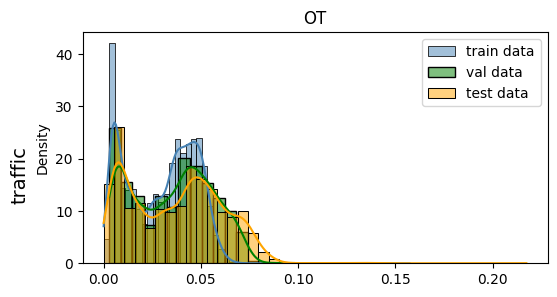

In [8]:
dataset_path = "/Users/shivanitomar/Documents/Implementations/FM_TUNE/fm-tune/datasets/traffic/traffic.csv"

timestamp_column = "date"

data = pd.read_csv(
    dataset_path,
    parse_dates=[timestamp_column],
)

# columns_to_drop = ["HUFL", "HULL", "MUFL", "MULL", "LUFL", "LULL"]
# data = data.drop(columns=columns_to_drop)

train_end = int(0.7*len(data))
val_end = train_end + int(0.1*len(data)) 


train_data = data[:train_end]
val_data = data[train_end : val_end]
test_data = data[val_end:]
print(len(train_data), len(val_data), len(test_data))

col = "OT"

plt.figure(figsize=(6, 3))
sns.histplot(train_data[col], color='steelblue', kde=True,
             stat='density', alpha=0.5, label='train data')
sns.histplot(val_data[col], color='green', kde=True,
             stat='density', alpha=0.5, label='val data')
sns.histplot(test_data[col], color='orange', kde=True,
             stat='density', alpha=0.5, label='test data')
plt.legend()
plt.xlabel('')
plt.ylabel('Density')
plt.title(col)
plt.suptitle("traffic", fontsize=14, x=0.02, y=0.5, rotation=90)
# plt.tight_layout()
plt.show()

### Metrics to quantify the distribution shifts between train/val/test : KL Divergence and Wasserstein Distance


In [7]:
import numpy as np
from scipy.stats import entropy, wasserstein_distance

col = "OT"

train_values = train_data[col]
val_values = val_data[col]
test_values = test_data[col]


# Define common histogram bins across all
bins = np.linspace(min(train_values.min(), val_values.min(), test_values.min()),
                   max(train_values.max(), val_values.max(), test_values.max()),
                   50)

# Compute normalized histograms (probability distributions)
train_hist, _ = np.histogram(train_values, bins=bins, density=True)
val_hist, _ = np.histogram(val_values, bins=bins, density=True)
test_hist, _ = np.histogram(test_values, bins=bins, density=True)

# Add small constant to avoid log(0)
eps = 1e-10
train_hist += eps
val_hist += eps
test_hist += eps

# --- KL Divergence (asymmetrical) ---
kl_train_val = entropy(train_hist, val_hist)
kl_train_test = entropy(train_hist, test_hist)
kl_val_test = entropy(val_hist, test_hist)

# --- Wasserstein (Earth Mover’s) Distance ---
wd_train_val = wasserstein_distance(train_values, val_values)
wd_train_test = wasserstein_distance(train_values, test_values)
wd_val_test = wasserstein_distance(val_values, test_values)

print(f"KL(train‖val): {kl_train_val:.4f}")
print(f"KL(train‖test): {kl_train_test:.4f}")
print(f"KL(val‖test): {kl_val_test:.4f}\n")

print(f"Wasserstein(train, val): {wd_train_val:.4f}")
print(f"Wasserstein(train, test): {wd_train_test:.4f}")
print(f"Wasserstein(val, test): {wd_val_test:.4f}")


KL(train‖val): 0.1857
KL(train‖test): 0.2596
KL(val‖test): 0.0761

Wasserstein(train, val): 0.0055
Wasserstein(train, test): 0.0076
Wasserstein(val, test): 0.0027


### Data preparation and setting seeds 

In [18]:
# Set seed for reproducibility
seeds = [44, 88, 22]
# SEED = 88, 11

# set_seed(SEED)

TTM_MODEL_PATH = "ibm-granite/granite-timeseries-ttm-r2"

CONTEXT_LENGTH = 512
PREDICTION_LENGTH = 96
BATCH_SIZE = 64
timestamp_column = "date"
TARGET_DATASET = "traffic"
dataset_path = "/Users/shivanitomar/Documents/Implementations/FM_TUNE/fm-tune/datasets/traffic/traffic.csv"


# Results dir
OUT_DIR = "ttm_finetuned_models/"


# columns
id_columns = []
target_columns = ['OT']
split_config = {
    "train": 0.7, 
    "test": 0.2
}
data = pd.read_csv(
    dataset_path,
    parse_dates=[timestamp_column],
)

column_specifiers = {
    "timestamp_column": timestamp_column,
    "id_columns": id_columns,
    "target_columns": target_columns,
    "control_columns": [],
    "observable_columns": []
}
tsp = TimeSeriesPreprocessor(
        **column_specifiers,
        context_length=CONTEXT_LENGTH,
        prediction_length=PREDICTION_LENGTH,
        scaling=True,
        encode_categorical=False,
        scaler_type="standard",
        freq= "1h",
    )
dset_train, dset_valid, dset_test = get_datasets(
        tsp, data, split_config
    )
print("Length of train/val/test", len(dset_train), len(dset_valid), len(dset_test))

Length of train/val/test 11673 1661 3413


### Running pipeline with following steps:
- Zeroshot predictions on Validation set
- Extracting high error validation samples using Error threshold
- learning shapelets using the smaller validation set
- 

In [ ]:
results = []
results_df_dir = f"results/{TARGET_DATASET}"
for SEED in seeds:
    
    print("*" * 120)
    print(f"Running experiments for seed:", SEED)

    RES_DIR = f"results/{TARGET_DATASET}/seed_{SEED}"
    PLOT_DIR = f"plots/{TARGET_DATASET}/seed_{SEED}"
    

    # zero-shot model 
    zeroshot_model = get_model(
        TTM_MODEL_PATH,
        context_length=CONTEXT_LENGTH,
        prediction_length=PREDICTION_LENGTH,
        freq_prefix_tuning=False,
        freq=None,
        prefer_l1_loss=False,
        prefer_longer_context=True,
        # Can also provide TTM Config args
        prediction_channel_indices=tsp.prediction_channel_indices,
        num_input_channels=tsp.num_input_channels
    )
    
    temp_dir = tempfile.mkdtemp()
    zeroshot_trainer = Trainer(
        model=zeroshot_model,
        args=TrainingArguments(
            output_dir=temp_dir,
            per_device_eval_batch_size=BATCH_SIZE,
            seed=SEED,
            report_to="none",
        ),
    )
    print("+" * 20, "VALIDATION MSE zero-shot", "+" * 20)
    val_zeroshot_output = zeroshot_trainer.evaluate(dset_valid)
    print("zeroshot output returned from evaluate() function", val_zeroshot_output)

    # extract high error val samples using error threshold
    zs_val_df = construct_output_df(dset_valid, zeroshot_trainer)
    zs_val_df["error"] = zs_val_df.apply(lambda row: mean_squared_error([row["prediction"]], [row["actual"]]), axis=1)

    mean_error = np.mean(zs_val_df["error"])
    std_error = np.std(zs_val_df["error"])
    err_threshold = mean_error + (2 * std_error)
    print("+" * 60)
    print("Average error on validation set :", mean_error)
    print("Error threshold for selecting validation samples for shapelet learning :", err_threshold)
  
    high_error_val_samples = zs_val_df[zs_val_df["error"] > err_threshold]
    # high_error_val_samples

    dual_plots(dataset=dset_valid, trainer=zeroshot_trainer, data_split="VALIDATION", model_type="zero-shot")


    # loading the fine-tuned model
    fft_model = TinyTimeMixerForPrediction.from_pretrained("/Users/shivanitomar/Documents/Implementations/granite-tsfm/notebooks/AAAI2026/ttm_finetuned_models/traffic/v1_fft/checkpoint-24820")
    temp_dir = tempfile.mkdtemp()

    fft_trainer = Trainer(
            model=fft_model,
            args=TrainingArguments(
                output_dir=temp_dir,
                per_device_eval_batch_size=64,
                seed=SEED,
                report_to="none",
            ),
        )
    fft_test_df = construct_output_df(dset_test, fft_trainer)
    fft_test_df["error"] = fft_test_df.apply(lambda row: mean_squared_error([row["prediction"]], [row["actual"]]), axis=1)


    # shapelet learning based on selected validation set
    
    context_array = np.array(high_error_val_samples["context"].tolist())
    n, p = context_array.shape
    print("Number of validation samples used for learning shapelet dictionary: ", n)
    r = 0.2 
    q = int(np.ceil(p * r))
    k = 50
    S, A, Offsets, F_obj = utils.USIDL_with_alpha_const(context_array, lambda_=0.1, K=k, q=q, c=100, epsilon=1e-5,
                                        maxIter=2e3, maxInnerIter=5, random_seed=SEED)
    shapelet_dict = {f'shapelet_{i}': S[i] for i in range(S.shape[0])}

    # saving all the shapelets in a pickle file
    filename = "all_shapelets.pkl"
    os.makedirs(RES_DIR, exist_ok=True)
    base_path = os.path.join(RES_DIR, filename)
    with open(base_path, 'wb') as f:
        pickle.dump(shapelet_dict, f)
    

    #rank shapelets based on alpha coeff to eliminate redundancy
    alpha_df = pd.DataFrame(A)
    k=25

    alpha_sum = alpha_df.sum(axis=0).to_frame().T
    topk_shap_idx = alpha_sum.iloc[0].nlargest(k).index
    df_top25 = alpha_sum[topk_shap_idx]

    select_shapelets = {}
    for key, value in shapelet_dict.items():
        idx = int(key.split("_")[1])
        if idx in topk_shap_idx:
            select_shapelets[key] = value

    # saving topK shapelets in a pickle file
    filename = "topK_shapelets.pkl"
    os.makedirs(RES_DIR, exist_ok=True)
    base_path = os.path.join(RES_DIR, filename)
    with open(base_path, 'wb') as f:
        pickle.dump(select_shapelets, f)

    def z_norm(x):
        return (x - np.mean(x)) / np.std(x)

    def shapelet_distance(segment, series):
        seg = z_norm(segment)
        series = z_norm(series)
        seg_len = len(seg)
        return min(np.linalg.norm(seg - series[i:i+seg_len]) for i in range(len(series)-seg_len+1))

    # User defined drop percentage to discard the number of predictions leading to high error
    percent = 0.2
    drop_limit = int(percent * len(dset_test))
    print("Allowed % of predictions that can be discarded :", percent)
    print("Allowed number of samples to be discarded :", drop_limit)

    test_distances_ed = np.zeros((len(dset_test),len(select_shapelets)))
    

    # save all the test distances with shapelets in an array
    for i in range(len(dset_test)):
        for j, shapelet in enumerate(select_shapelets.values()):
            series = np.array(dset_test[i]["past_values"].squeeze(1))
            dist = shapelet_distance(shapelet, series)
            test_distances_ed[i, j] = dist
    
    print("test_distances calculated ")

    # import warnings
    # distance 
    min_dists = test_distances_ed.min(axis=1)
    sorted_idx = np.argsort(min_dists)
    samples_to_drop = sorted_idx[:drop_limit]

    total_error_zs = []
    total_error_fft = []

    for i in range(len(dset_test)):
        if i in samples_to_drop:
            # print("Discarding the sample due to high similarity with one of the shapelets")
            dis = 0
            total_error_zs.append(dis)
            total_error_fft.append(dis)

        else:
            # with warnings.catch_warnings():
            #     warnings.simplefilter("ignore")

            # using zs model to predict the remaining test samples
            zs_preds_dict = zeroshot_trainer.predict([dset_test[i]])
            zs_preds = zs_preds_dict.predictions[0]
            zs_preds = zs_preds.squeeze(0)
            actual = np.array(dset_test[i]["future_values"])
            zs_error = mean_squared_error(zs_preds, actual)
            total_error_zs.append(zs_error)

            # using the fft model to predict the remaining test samples
            fft_preds_dict = fft_trainer.predict([dset_test[i]])
            fft_preds = fft_preds_dict.predictions[0]
            fft_preds = fft_preds.squeeze(0)
            fft_error = mean_squared_error(fft_preds, actual)
            total_error_fft.append(fft_error)

    print("discarding loop complete")

    # Error after discarding allowed unreliable predictions
    # print("Average error after discarding 10\% of the predictions due to close matches with shapelets: ", np.mean(total_error))
    discard_df = pd.DataFrame(total_error_zs, columns=["zs_error"])

    
    discard_df["fft_error"] = total_error_fft



# plotting the same two plots for test set

    dual_plots(dataset=dset_test, trainer=zeroshot_trainer, data_split="TEST", model_type="zero-shot")

    zs_test_df = construct_output_df(dset_test, zeroshot_trainer)
    zs_test_df["error"] = zs_test_df.apply(lambda row: mean_squared_error([row["prediction"]], [row["actual"]]), axis=1)
    discard_df['date'] = zs_test_df["date"]

    
    # plotting 2 cases : 1. plot showing discarded close matching samples and using ZS model for remaining predictions.
    #                    2. plot showing discarded close matching samples and using FT model for remaining predictions.


    ax_final = zs_test_df.plot(
        x="date",
        y="error",
        figsize=(25, 5),     
        label="Zero-shot Model",
        title="MSE per sample on the test set using zero-shot model, fine-tuned and post discarding unreliable predictions"
    )

    fft_test_df.plot(
        x="date",
        y="error",
        ax=ax_final,
        label="Fine-tuned model"

    )


    discard_df.plot(
        x="date",
        y="zs_error",
        ax=ax_final,
        label="After discarded predictions (using ZS)"

    )

    discard_df.plot(
        x="date",
        y="fft_error",
        ax=ax_final,
        label="After discarded predictions (using FFT)"

    )
    if PLOT_DIR is not None:
        plot_final = "final_comparison_plot.pdf"
        os.makedirs(PLOT_DIR, exist_ok=True)
        fig_final = ax_final.get_figure()
        fig_final.savefig(os.path.join(PLOT_DIR, plot_final))
    
    # Store results
    results.append({
        "seed": SEED,
        "zs_error": np.mean(zs_test_df["error"]),
        "fft_error": np.mean(fft_test_df["error"]),
        "discard_using_zs": np.mean(discard_df["zs_error"]),
        "discard_using_fft": np.mean(discard_df["fft_error"])
        # "discard_using_random"
    })

results_df = pd.DataFrame(results)
results_filename = "results_all_seeds.csv"
os.makedirs(results_df_dir, exist_ok=True)
results_path = os.path.join(results_df_dir, results_filename)
results_df.to_csv(results_path, index=False)
print(f"Results saved to: {results_path}")

INFO:p-39523:t-8327335808:get_model.py:get_model:Loading model from: ibm-granite/granite-timeseries-ttm-r2


************************************************************************************************************************
Running experiments for seed: 44


INFO:p-39523:t-8327335808:get_model.py:get_model:Model loaded successfully from ibm-granite/granite-timeseries-ttm-r2, revision = main.
INFO:p-39523:t-8327335808:get_model.py:get_model:[TTM] context_length = 512, prediction_length = 96


++++++++++++++++++++ VALIDATION MSE zero-shot ++++++++++++++++++++


zeroshot output returned from evaluate() function {'eval_loss': 0.10885836184024811, 'eval_model_preparation_time': 0.0013, 'eval_runtime': 1.0471, 'eval_samples_per_second': 1586.289, 'eval_steps_per_second': 24.831}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Average error on validation set : 0.10885835202645532
Error threshold for selecting validation samples for shapelet learning : 0.2408931764470585


Number of validation samples used for learning shapelet dictionary:  103
setting random seed to 44 for dictionary initialization
Converged!
Allowed % of predictions that can be discarded : 0.2
Allowed number of samples to be discarded : 682
test_distances calculated 


 ## Few-shot finetune and evaluation method

In [14]:
SEED=44

In [15]:
def fewshot_finetune_eval(
    dataset_name,
    batch_size,
    learning_rate=None,
    context_length=512,
    forecast_length=96,
    fewshot_percent=100,
    freeze_backbone=True,
    num_epochs=10,
    save_dir=OUT_DIR,
    loss="mse",
    quantile=0.5,
):
    out_dir = os.path.join(save_dir, dataset_name)

    print("-" * 20, f"Running few-shot {fewshot_percent}%", "-" * 20)

    # Data prep: Get dataset
    

    tsp = TimeSeriesPreprocessor(
        **column_specifiers,
        context_length=context_length,
        prediction_length=forecast_length,
        scaling=True,
        encode_categorical=False,
        scaler_type="standard",
    )
    print("+" * 20, "TSP values", "+" * 20)
    print(tsp.prediction_channel_indices)
    print(tsp.exogenous_channel_indices)
    print(tsp.context_length)
    print(tsp.prediction_length)
    print(tsp.num_input_channels)
    print(tsp.scaler_type)




    # change head dropout to 0.7 for ett datasets
    if "ett" in dataset_name:
        finetune_forecast_model = get_model(
            TTM_MODEL_PATH,
            context_length=context_length,
            prediction_length=forecast_length,
            freq_prefix_tuning=False,
            freq=None,
            prefer_l1_loss=False,
            prefer_longer_context=True,
            # Can also provide TTM Config args
            prediction_channel_indices=tsp.prediction_channel_indices,
            num_input_channels=tsp.num_input_channels,

            head_dropout=0.7,
            loss=loss,
            quantile=quantile,
        )
    else:
        finetune_forecast_model = get_model(
            TTM_MODEL_PATH,
            context_length=context_length,
            prediction_length=forecast_length,
            freq_prefix_tuning=False,
            freq=None,
            prefer_l1_loss=False,
            prefer_longer_context=True,
            head_dropout=0.2,
            # Can also provide TTM Config args
            loss=loss,
            quantile=quantile,
        )

    dset_train, dset_val, dset_test = get_datasets(
        tsp,
        data,
        split_config,
        fewshot_fraction=fewshot_percent / 100,
        fewshot_location="first",
        use_frequency_token=finetune_forecast_model.config.resolution_prefix_tuning,
        
    )
    print("after get_datasets ------", len(dset_train))

    if freeze_backbone:
        print(
            "Number of params before freezing backbone",
            count_parameters(finetune_forecast_model),
        )

        # Freeze the backbone of the model
        for param in finetune_forecast_model.backbone.parameters():
            param.requires_grad = False

        # Count params
        print(
            "Number of params after freezing the backbone",
            count_parameters(finetune_forecast_model),
        )

    # Find optimal learning rate
    # Use with caution: Set it manually if the suggested learning rate is not suitable
    if learning_rate is None:
        learning_rate, finetune_forecast_model = optimal_lr_finder(
            finetune_forecast_model,
            dset_train,
            batch_size=batch_size,
        )
        print("OPTIMAL SUGGESTED LEARNING RATE =", learning_rate)

    print(f"Using learning rate = {learning_rate}")
    finetune_forecast_args = TrainingArguments(
        output_dir=os.path.join(out_dir, "v1_fft"),
        overwrite_output_dir=True,
        learning_rate=learning_rate,
        num_train_epochs=num_epochs,
        do_eval=True,
        eval_strategy="epoch",
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        dataloader_num_workers=8,
        report_to="none",
        save_strategy="epoch",
        logging_strategy="epoch",
        save_total_limit=1,
        logging_dir=os.path.join(out_dir, "logs"),  # Make sure to specify a logging directory
        load_best_model_at_end=True,  # Load the best model when training ends
        metric_for_best_model="eval_loss",  # Metric to monitor for early stopping
        greater_is_better=False,  # For loss
        seed=SEED,
    )

    # Create the early stopping callback
    early_stopping_callback = EarlyStoppingCallback(
        early_stopping_patience=5,  # Number of epochs with no improvement after which to stop
        early_stopping_threshold=1e-5,  # Minimum improvement required to consider as improvement
    )
    tracking_callback = TrackingCallback()

    # Optimizer and scheduler
    optimizer = AdamW(finetune_forecast_model.parameters(), lr=learning_rate)
    scheduler = OneCycleLR(
        optimizer,
        learning_rate,
        epochs=num_epochs,
        steps_per_epoch=math.ceil(len(dset_train) / (batch_size)),
    )

    finetune_forecast_trainer = Trainer(
        model=finetune_forecast_model,
        args=finetune_forecast_args,
        train_dataset=dset_train,
        eval_dataset=dset_val,
        callbacks=[early_stopping_callback, tracking_callback],
        optimizers=(optimizer, scheduler),
    )
    finetune_forecast_trainer.remove_callback(INTEGRATION_TO_CALLBACK["codecarbon"])

    # Fine tune
    finetune_forecast_trainer.train()

    # Evaluation
    print("+" * 20, f"Test MSE after few-shot {fewshot_percent}% fine-tuning", "+" * 20)

    finetune_forecast_trainer.model.loss = "mse"  # fixing metric to mse for evaluation

    fewshot_output = finetune_forecast_trainer.evaluate(dset_test)
    print(fewshot_output)
    print("+" * 60)

    # get predictions

    predictions_dict = finetune_forecast_trainer.predict(dset_test)
    print("prediction metrics on test set", predictions_dict[2])

    predictions_np = predictions_dict.predictions[0]

    print(predictions_np.shape)

    # get backbone embeddings (if needed for further analysis)

    backbone_embedding = predictions_dict.predictions[1]

    print(backbone_embedding.shape)

    # plot
    plot_predictions(
        model=finetune_forecast_trainer.model,
        dset=dset_test,
        plot_dir=os.path.join(OUT_DIR, dataset_name),
        plot_prefix="test_fewshot",
        indices=[685, 118, 902],
        channel=0,
    )
    return predictions_dict

### Fine-tuning on full dataset (using 100% train split)

INFO:p-39523:t-8327335808:get_model.py:get_model:Loading model from: ibm-granite/granite-timeseries-ttm-r2


-------------------- Running few-shot 100% --------------------
++++++++++++++++++++ TSP values ++++++++++++++++++++
[0]
[]
512
96
1
standard


INFO:p-39523:t-8327335808:get_model.py:get_model:Model loaded successfully from ibm-granite/granite-timeseries-ttm-r2, revision = main.
INFO:p-39523:t-8327335808:get_model.py:get_model:[TTM] context_length = 512, prediction_length = 96


after get_datasets ------ 11673
Number of params before freezing backbone 805280
Number of params after freezing the backbone 289696
Using learning rate = 0.0001


Epoch,Training Loss,Validation Loss
1,0.076900,0.086876
2,0.072100,0.081197
3,0.068200,0.075546
4,0.064300,0.073988
5,0.061800,0.071924
6,0.059800,0.070735
7,0.058200,0.068952
8,0.057000,0.070130
9,0.055900,0.068427
10,0.055200,0.068303


[TrackingCallback] Mean Epoch Time = 85.33354507684707 seconds, Total Train Time = 2919.253718852997
++++++++++++++++++++ Test MSE after few-shot 100% fine-tuning ++++++++++++++++++++


{'eval_loss': 0.11726327240467072, 'eval_runtime': 62.4851, 'eval_samples_per_second': 54.621, 'eval_steps_per_second': 6.834, 'epoch': 20.0}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
prediction metrics on test set {'test_loss': 0.11726327240467072, 'test_runtime': 67.489, 'test_samples_per_second': 50.571, 'test_steps_per_second': 6.327}
(3413, 96, 1)
(3413, 1, 8, 192)


PredictionOutput(predictions=(array([[[-0.27602446],
        [-0.6435211 ],
        [-0.98322654],
        ...,
        [ 1.6938099 ],
        [ 1.2150753 ],
        [ 0.7386795 ]],

       [[-0.61613107],
        [-0.9333121 ],
        [-1.2431133 ],
        ...,
        [ 1.2353708 ],
        [ 0.7519208 ],
        [ 0.233452  ]],

       [[-0.94203705],
        [-1.1781585 ],
        [-1.4115405 ],
        ...,
        [ 0.7486758 ],
        [ 0.23345613],
        [-0.34747934]],

       ...,

       [[-0.6879703 ],
        [-1.0588075 ],
        [-1.2508811 ],
        ...,
        [ 0.88932097],
        [ 0.46654582],
        [ 0.13067737]],

       [[-1.0899644 ],
        [-1.2968993 ],
        [-1.411861  ],
        ...,
        [ 0.46674186],
        [ 0.15413678],
        [-0.20128942]],

       [[-1.313056  ],
        [-1.4151943 ],
        [-1.4746323 ],
        ...,
        [ 0.11644512],
        [-0.22064292],
        [-0.6144151 ]]], dtype=float32), array([[[[-0.10680233, 

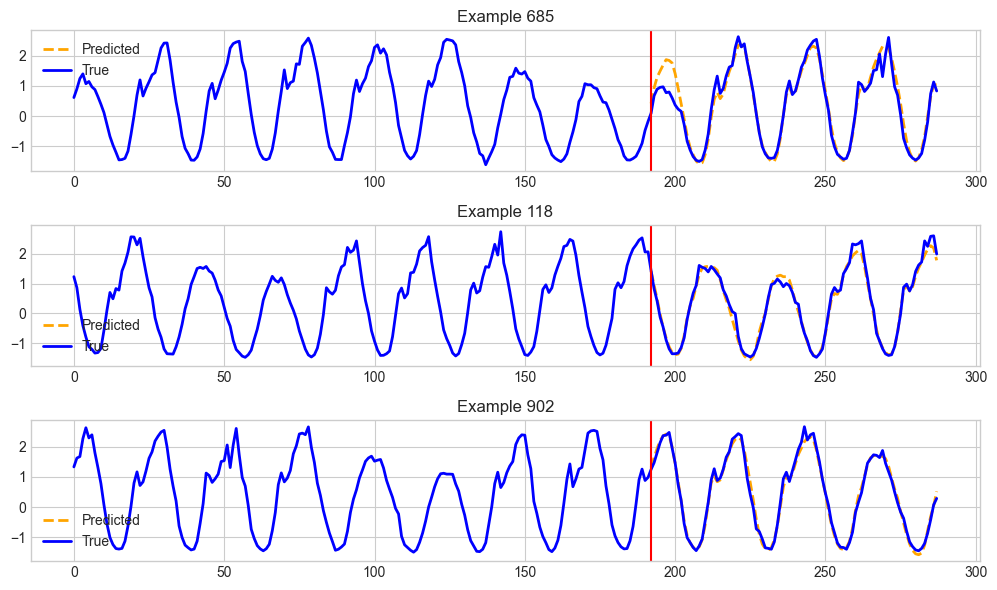

In [17]:
fewshot_finetune_eval(
    dataset_name=TARGET_DATASET,
    context_length=CONTEXT_LENGTH,
    forecast_length=PREDICTION_LENGTH,
    batch_size=8,
    fewshot_percent=100,
    learning_rate=0.0001,
    num_epochs=20,
)

In [ ]:
fft_model = TinyTimeMixerForPrediction.from_pretrained("/Users/shivanitomar/Documents/Implementations/granite-tsfm/notebooks/AAAI2026/ttm_finetuned_models/exchange_rate/v1_fft/checkpoint-518")
temp_dir = tempfile.mkdtemp()

fft_trainer = Trainer(
        model=fft_model,
        args=TrainingArguments(
            output_dir=temp_dir,
            per_device_eval_batch_size=64,
            seed=SEED,
            report_to="none",
        ),
    )
fft_test_df = construct_output_df(dset_test, fft_trainer)

In [2]:
import pandas as pd

edf = pd.read_csv("/Users/shivanitomar/Documents/Implementations/FM_TUNE/fm-tune/datasets/electricity/electricity.csv")
edf

,date,0,1,2,3,4,5,6,7,8,...,311,312,313,314,315,316,317,318,319,OT
0,2016-07-01 02:00:00,14.0,69.0,234.0,415.0,215.0,1056.0,29.0,840.0,226.0,...,676.0,372.0,80100.0,4719.0,5002.0,48.0,38.0,1558.0,182.0,2162.0
1,2016-07-01 03:00:00,18.0,92.0,312.0,556.0,292.0,1363.0,29.0,1102.0,271.0,...,805.0,452.0,95200.0,4643.0,6617.0,65.0,47.0,2177.0,253.0,2835.0
2,2016-07-01 04:00:00,21.0,96.0,312.0,560.0,272.0,1240.0,29.0,1025.0,270.0,...,817.0,430.0,96600.0,4285.0,6571.0,64.0,43.0,2193.0,218.0,2764.0
3,2016-07-01 05:00:00,20.0,92.0,312.0,443.0,213.0,845.0,24.0,833.0,179.0,...,801.0,291.0,94500.0,4222.0,6365.0,65.0,39.0,1315.0,195.0,2735.0
4,2016-07-01 06:00:00,22.0,91.0,312.0,346.0,190.0,647.0,16.0,733.0,186.0,...,807.0,279.0,91300.0,4116.0,6298.0,75.0,40.0,1378.0,191.0,2721.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26299,2019-07-01 21:00:00,11.0,116.0,8.0,844.0,384.0,1590.0,51.0,1412.0,407.0,...,1897.0,1589.0,166500.0,9917.0,10412.0,324.0,21.0,1870.0,162.0,2773.0
26300,2019-07-01 22:00:00,11.0,103.0,8.0,749.0,371.0,1366.0,47.0,1265.0,369.0,...,1374.0,1336.0,158800.0,6812.0,8956.0,302.0,20.0,1506.0,438.0,2755.0
26301,2019-07-01 23:00:00,12.0,93.0,8.0,650.0,346.0,1282.0,48.0,1079.0,308.0,...,938.0,1311.0,154300.0,6602.0,5910.0,302.0,18.0,1864.0,621.0,2650.0
26302,2019-07-02 00:00:00,10.0,92.0,8.0,646.0,349.0,1261.0,48.0,1009.0,288.0,...,833.0,1227.0,141900.0,6546.0,5502.0,259.0,33.0,2623.0,783.0,2719.0
